# TensorFlow, Bands2Vec and TSNE
---------------------------------------------------------


Learning the “TensorFlow way” to build a neural network can seem like a big hurdle to getting started with machine learning. In this tutorial, we’ll take it step by step and explain all of the critical components involved as we build a Bands2Vec model using Pitchfork data from Kaggle. For the full code, check out the GitHub page.

**The Word2Vec Model**

Neural networks consume numbers and produce numbers. They’re very good at it. But give them some text, and they’ll throw a tantrum and do nothing remotely interesting. If it is the neural network’s job to crunch the numbers and produce meaningful output, then it is our job to make sure that whatever we are feeding it is meaningful too. This quest for a meaningful representation of information gave birth to the Word2Vec model.

One approach to working with words is to form one-hot encoded vectors. Create a long (the number of distinct words in our vocabulary) list of zeroes, and have each word point to a unique index of this list. If we see this word, make that index in the list a number one.

While this approach works, it requires a lot space and is completely devoid of meaning. ‘Good’ and ‘Excellent’ are as similar as ‘Duck’ and ‘Blackhole’. If only there was a way to vectorise words so that we preserved this contextual similarity…

Thankfully, there is a way!

Using a neural network, we can produce ‘embeddings’ of our words. These are vectors that represent each unique word extracted from the weights of the connections within our network.

But the question remains: how do we make sure they’re meaningful? The answer: feed in pairs of words as a target word and a context word. Do this enough times, throwing in some bad examples too, and the neural network begins to learn what words appear together and how this forms almost a graph. Like a social network of words interconnected by contexts. ‘Good’ goes to ‘helpful’ which goes to ‘caring’ and so on. Our task is to feed this data into the neural network.

One of the most common approaches is the Skipgram model, generating these target-context pairings based on moving a window across a dataset of text. But what if our data isn’t sentences, but we still have contextual meaning? In this tutorial, our words are artist names and our contexts are genres and mean review scores. We want artist A to be close to artist B if they share a genre and have a mean review score that is similar. So let’s get started.

# Building our Dataset
Pitchfork is an online American music magazine covering mostly rock, independent, and new music. The data released to Kaggle was scraped from their website and contains information like reviews, genres, and dates linked to each artist.
Let’s create an artist class and dictionary to store all of the useful information we want.


In [1]:
import sqlite3 as sql
import numpy as np

In [2]:
# Connecting to the Kaggle Pitchfork Database 
db = sql.connect('data/pitchfork.sqlite')
cursor = db.cursor()

#db = sql.connect('../../data/pitchfork.sqlite')
#cursor = db.cursor()

artist_dict = {}
artist_lookup = {}

#An artist class for holding the information
class Artist:
    def __init__(self, name):
        self.name = name
        self.reviews = []
        self.genres = []
        self.scores = []
    def add_review(self, review):
        self.reviews.append(review)
    def add_genre(self, genre):
        self.genres.append(genre)
    def add_score(self, score):
        self.scores.append(score)
    def __str__(self):
        return self.name

#Reading in the data and storing it as Aritst objects in our dictionary
cursor.execute('select reviews.reviewid, artist, genre, score from reviews join genres on genres.reviewid = reviews.reviewid')
for row in cursor:
    if row[1] not in artist_dict:
        artist_dict[row[1]] = Artist(row[1])
        artist_dict[row[1]].add_review(row[0])
        artist_dict[row[1]].add_genre(row[2])
        artist_dict[row[1]].add_score(row[3])
        artist_lookup[row[1]] = len(artist_lookup)
    else: 
        artist_dict[row[1]].add_review(row[0])
        artist_dict[row[1]].add_genre(row[2])
        artist_dict[row[1]].add_score(row[3])

Great! Now we want to manufacture our target-context pairings based on genre and mean review score. To do this, we’ll create two dictionaries: one for the different unique genres, and one for the scores (discretised to integers).
We’ll add all our artists to the corresponding genre and mean score in these dictionaries to use later when generating pairs of artists.

In [3]:
genres = {}
genre_lookup = {}
scores = {}
cursor.execute('select distinct genre from genres')
for row in cursor:
    genre_lookup[len(genre_lookup)] = row[0] 
    genres[row[0]] = []
    
for i in range(11):
    scores[i] = []
    
for artist in artist_dict: 
    for genre in artist_dict[artist].genres:
        #We don't want to add them more than once - although maybe this could be a weighting
        #as in how 'rocky' are the band?
        if artist not in genres[genre]:
            genres[genre].append(artist_lookup[artist])
    mean_score = np.mean(artist_dict[artist].scores)
    scores[round(mean_score)].append(artist_lookup[artist])

One last step before we dive into the TensorFlow code: generating a batch! A batch is like a sample of data that our neural network will use for each epoch. An epoch is one sweep across the neural network in a training phase. We want to generate two numpy arrays. One will contain the following code:

In [4]:
def gen_batch(genres, scores, size, bias):
    xs = np.ndarray(shape=(size), dtype=np.int32)
    ys = np.ndarray(shape=(size, 1), dtype=np.int32)
    for idx in range(size):
        b = np.random.randint(10)
        if b < bias:
            genre = np.random.randint(len(genres))
            g1 = np.random.randint(len(genres[genre_lookup[genre]]))
            g2 = np.random.randint(len(genres[genre_lookup[genre]]))
            while g1 == g2:
                g2 = np.random.randint(len(genres[genre_lookup[genre]]))
            xs[idx] = genres[genre_lookup[genre]][g1]
            ys[idx][0] = genres[genre_lookup[genre]][g2]
        else:
            score = np.random.randint(len(scores))
            s1 = np.random.randint(len(scores[score]))
            s2 = np.random.randint(len(scores[score]))
            while s1 == s2:
                s2 = np.random.randint(len(scores[score]))
            xs[idx] = scores[score][s1]
            ys[idx][0] = scores[score][s2]
    return xs, ys

artist_decode = dict(zip(artist_lookup.values(), artist_lookup.keys()))

# TensorFlow
There are a myriad of TensorFlow tutorials and sources of knowledge out there. Any of these excellent articles will help you as well as the documentation. The following code is heavily based on the word2vec tutorial from the TensorFlow people themselves. Hopefully I can demystify some of it and boil it down to the essentials.
The first step is understanding the ‘graph’ representation. This is incredibly useful for the TensorBoard visualisations and for creating a mental image of the data flows within the neural network.
Take some time to read through the code and comments below. Before we feed data to a neural network, we have to initialise all of the parts we’re going to use. The placeholders are the inputs taking whatever we give the ‘feed_dict’. The variables are mutable parts of the graph that we will eventually tweak. The most important part of our model is the loss function. It’s the score of how well we did and the treasure map to how we can improve.

In [5]:
xs, ys = gen_batch(genres, scores, 64, 6)

In [6]:
#Before we dive in we need to declare some variables
vocabulary_size = len(artist_lookup)
#How big we want our final vectors to be
embedding_size = 64
#The number of training samples passed per epoch
batch_size = 64
#Number of negative samples to use in NCE [see below]
num_sampled = 16

In [7]:
#BAND2VEC - Tensorflow Time!
import tensorflow as tf
import math 

graph = tf.Graph()

with graph.as_default():
    #Defining variables and functions in a scope is good practice
    with tf.name_scope('inputs'):
        #Tensorflow Placeholders are the mouths of the neural network - they will constantly be fed new information
        training_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        training_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    #Using the CPU
    with tf.device('/cpu:0'):
        with tf.name_scope('embeddings'):
            #The embeddings - variables are maintained across runs and need to be initialised with a shape and type
            #Each row is a band represented by a vector of length 'embedding_size'
            embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
            #Like passing muliple indices to a numpy array we get the vectors quickly with this function
            embed = tf.nn.embedding_lookup(embeddings, training_inputs)
        
        with tf.name_scope('weights'):
            #Like embeddings we initialise our weights and also...
            nce_weights = tf.Variable(
                tf.truncated_normal(
                    [vocabulary_size, embedding_size],
                    stddev=1.0 / math.sqrt(embedding_size)))
            
        with tf.name_scope('biases'):
            #...our biases
            nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
            
    with tf.name_scope('loss'):
        #Finally our loss function - see below for an explanation of the Noise Contrastive Estimation Approach
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=training_labels,
                inputs=embed,
                num_sampled=num_sampled,
                num_classes=vocabulary_size))
        
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

/Users/user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Noise Contrastive Estimation (NCE) is a loss function. Usually we would use cross-entropy and softmax, but in the natural language processing world, all of our classes amount to every single unique word.

Computationally, this is bad. NCE changes the framing of the problem from probabilities of classes to whether or not a target-context pairing is correct (a binary classification). It takes a true pairing and then samples to get bad pairings, the constant num_sampled controls this. Our neural network learns to distinguish between these good and bad pairings. Ultimately, it learns the contexts! You can read more about NCE and how it works here.

**Run the Neural Network**
Now that everything is set up nicely, we just have to hit the big green ‘go’ button and twiddle our thumbs for a bit.

In [8]:
#Running our Neural Network!
#First we init the session

iterations = 100000

with tf.Session(graph=graph) as sess:
    #We run the initialize all global variables operation
    sess.run(tf.global_variables_initializer())
    average_loss = 0.0
    #For all of the iterations
    for index in range(iterations):
        #Generate a batch
        ti, tl = gen_batch(genres, scores, batch_size, 8)
        feed_dict = {training_inputs: ti, training_labels: tl}
        #Run the NN! Notice the feed dict feeding our placeholders from before
        _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
        #Some metrics so we can see how we're doing
        average_loss += loss_val
        if (index + 1) % 2000 == 0:
            print('Average loss at step', index + 1, average_loss / (index + 1))
            
    final_embeddings = embeddings.eval()

Average loss at step 2000 33.14068664956093
Average loss at step 4000 23.402247108101843
Average loss at step 6000 18.16870211215814
Average loss at step 8000 14.95871063950658
Average loss at step 10000 12.759956971132755
Average loss at step 12000 11.199593711336453
Average loss at step 14000 10.030287233914647
Average loss at step 16000 9.11698679149896
Average loss at step 18000 8.385561496072345
Average loss at step 20000 7.788537426400184
Average loss at step 22000 7.2869991482008585
Average loss at step 24000 6.861746156727274
Average loss at step 26000 6.496615246621462
Average loss at step 28000 6.180633869518127
Average loss at step 30000 5.900388147495191
Average loss at step 32000 5.653681166421622
Average loss at step 34000 5.433373031511026
Average loss at step 36000 5.234981084614992
Average loss at step 38000 5.056138832810678
Average loss at step 40000 4.894306624060869
Average loss at step 42000 4.745909847719329
Average loss at step 44000 4.609728648097677
Average lo

# **Visualization using TSNE**

Okay, we’re not quite done. We now have context-rich, 64-dimensional vectors for our artists, but that’s perhaps too many dimensions to really visualize its usefulness.

Lucky for us we can squash this information into two dimensions while retaining as many of the properties as the 64 dimensions had! This is T-distributed Stochastic Neighbor Embedding, or TSNE for short. This video does a great job of explaining the main idea behind TSNE, but I’ll try to give a broad overview.

TSNE is an approach to dimensionality reduction that retains the similarities (like Euclidean distance) of higher dimensions. To do this, it first builds a matrix of point-to-point similarities calculated using a normal distribution. The centre of the distribution is the first point, and the similarity of the second point is the value of the distribution at the distance between the points away from the centre of the distribution.

Then we project randomly onto the dimension below and do exactly the same process using a t-distribution. Now we have two matrices of point-to-point similarities. The algorithm then slowly moves the points in the lower dimension to try and make it look like the matrix for the higher dimension where the similarities were preserved. And repeat. Thankfully, Sci-kit Learn has a function which can do the number crunching for us.


In [9]:
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, verbose=1, init='pca', n_iter=500, method='exact')
    plot_only = len(artist_lookup)
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 8715
[t-SNE] Computed conditional probabilities for sample 2000 / 8715
[t-SNE] Computed conditional probabilities for sample 3000 / 8715
[t-SNE] Computed conditional probabilities for sample 4000 / 8715
[t-SNE] Computed conditional probabilities for sample 5000 / 8715
[t-SNE] Computed conditional probabilities for sample 6000 / 8715
[t-SNE] Computed conditional probabilities for sample 7000 / 8715
[t-SNE] Computed conditional probabilities for sample 8000 / 8715
[t-SNE] Computed conditional probabilities for sample 8715 / 8715
[t-SNE] Mean sigma: 1.107011
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.823166
[t-SNE] Error after 500 iterations: 3.449377


In [10]:
#Given a low dimension embedding, find the clostest point to it using Euclidean Distance
from sklearn.metrics.pairwise import euclidean_distances
def find_closest_n(band_embedding, n=1):
    closest = []
    for idx, lde in enumerate(low_dim_embs):
        differences = euclidean_distances([band_embedding], low_dim_embs)
        idxs = np.argsort(differences)
    for i in idxs[0, :n]:
        closest.append(artist_decode[i])
    return closest


def top_n_similar_artists(word, n):
    index = artist_lookup[word]
    vector_representation = low_dim_embs[index]
    esim = euclidean_distances([vector_representation], low_dim_embs)
    eindices = np.argsort(esim)
    top_n = []
    for id1 in eindices[0][:n]:
        top_n.append(artist_decode[id1])
    return top_n

In [11]:
#Kmeans - https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=len(genres))
kmeans.fit(low_dim_embs)
y_kmeans = kmeans.predict(low_dim_embs)

# The Results

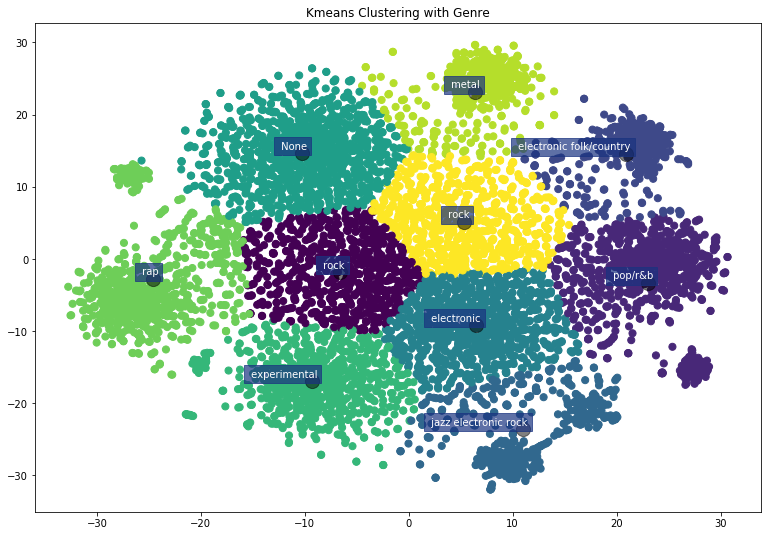

In [12]:
fig, ax = plt.subplots(figsize=(13, 9))
ax.scatter(low_dim_embs[:, 0], low_dim_embs[:, 1], c=y_kmeans, s=50, cmap='viridis')

centres = kmeans.cluster_centers_
centres_labels = []
for centre in centres:
    top_5 = find_closest_n(centre, 5)
    labels = ""
    for artist in top_5:
        g = artist_dict[artist].genres[0]
        if g == None: 
            g = 'None'
        if g not in labels.split(): 
            labels += (' ' + (g))
    centres_labels.append(labels)
    
for idx, label in enumerate(centres_labels):
        x, y = centres[idx, :]
        ax.scatter(x, y, c='black', s=200, alpha=0.5)
        ax.annotate(label,xy=(x, y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom', color='white', backgroundcolor=(0.1, 0.2, 0.5, 0.7)) 
        
ax.set_title('Kmeans Clustering with Genre')
plt.savefig('./KMEANS_CLUSTERING.png')

The amazing aspect of these embeddings is that, just like vectors, they support mathematical operations. The classic example being: King — Man + Woman = Queen , or at least very close to it. Let’s try an example.

Take the low dimensional embeddings of Coil, a band with the following genres, [‘electronic’, ‘experimental', ‘rock’] , and mean score 7.9. Now subtract the low dimensional embeddings of Elder Ones, a band with genres,['electronic'] , and mean score 7.8. With this embedding difference, find the closest bands to it and print their names and genres.
Artist: black lips, Mean Score: 7.48, Genres: ['rock', 'rock', 'rock', 'rock', 'rock']
Artist: crookers, Mean Score: 5.5, Genres: ['electronic']
Artist: guided by voices, Mean Score: 7.23043478261, Genres: ['rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock']

It worked! We’re getting rock and electronic bands with vaguely similar review scores. Below are the first three hundred bands plotted with labels. Hopefully you’ve found this project educational and inspiring. Go forth and build, explore, and play!

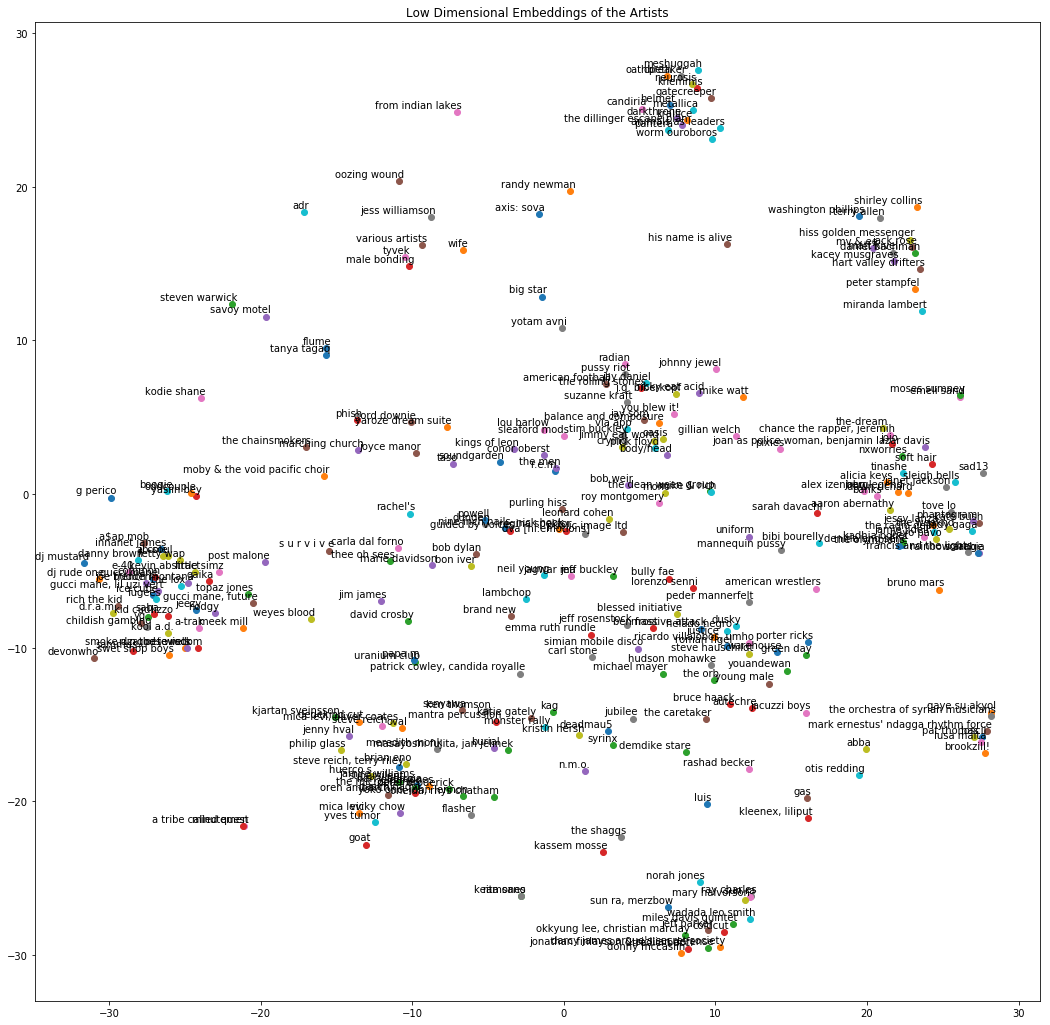

In [13]:
from tempfile import gettempdir
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',ha='right',va='bottom')
    plt.title('Low Dimensional Embeddings of the Artists')
    #plt.show()
    plt.savefig('./FIRST_300.png')

labels = []
for i in range(300):
    if artist_decode[i] != 'joey bada$$':
        labels.append(artist_decode[i])
plot_with_labels(low_dim_embs, labels, './other.png')

In [14]:
print(artist_dict['coil'].genres, np.mean(artist_dict['coil'].scores))
print(artist_dict['elder ones'].genres, np.mean(artist_dict['elder ones'].scores))
electronic_experimental = low_dim_embs[artist_lookup['coil']] - low_dim_embs[artist_lookup['elder ones']]

['electronic', 'experimental', 'rock'] 7.900000000000001
['experimental'] 7.8


In [15]:
bands = find_closest_n(electronic_experimental, 3)
for band in bands:
    print(band, 'Mean Score:' , np.mean(artist_dict[band].scores), 'Genres:', artist_dict[band].genres)

the muffs Mean Score: 7.5 Genres: ['rock']
world leader pretend Mean Score: 6.5 Genres: ['rock']
the cloud room Mean Score: 6.6 Genres: ['electronic', 'rock']
